Enter your OpenAI API key:  ········


Loading existing vector index...


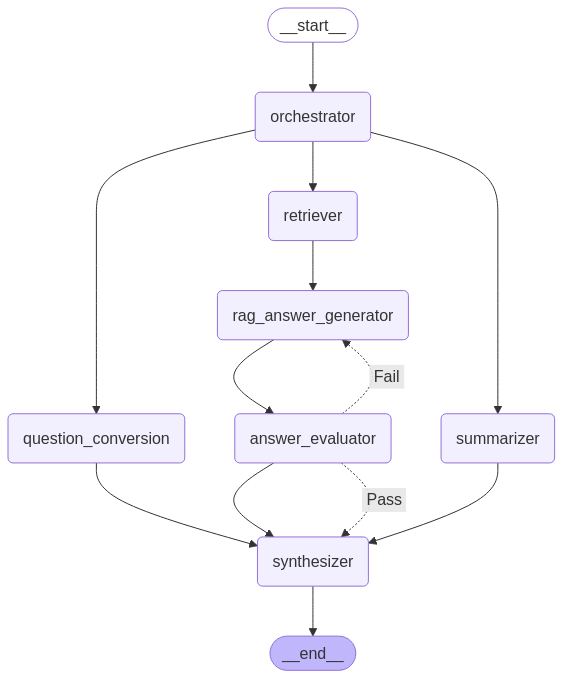

[Orchestrator] Received question: Hvordan kan jeg bake en perfekt mørk sjokoladekake?
[Retriever] Found 3 relevant contexts
Context 1 (excerpt): Norwegian Chocolate Cake (Sjokoladekake)
                
                Ingredients:
             ...
Context 2 (excerpt): Classic Chocolate Cake Recipe
                
                Ingredients:
                - 2 cups...
Context 3 (excerpt): Perfect Moist Chocolate Cake
                
                Ingredients:
                - 250g al...
[Question Conversion] Converted question: Hva er hemmeligheten bak å bake en perfekt mørk sjokoladekake?
[Question Summary] Summary: Hvordan kan jeg lage en optimal mørk sjokoladekake?
[RAG Answer Generator] RAG answer: For å bake en perfekt mørk sjokoladekake, kan du følge oppskriften på den norske sjokoladekaken fra Context 1. Denne kaken er designet for å være fuktig og litt seig i midten, nesten som en brownie. Her er en oppsummering av fremgangsmåten:

1. Forvarm ovnen til 180°C og kle en 24

In [1]:
#llama_index RAG included in the langgraph workflpw
# LangGraph RAG Workflow

#This notebook implements a Retrieval-Augmented Generation (RAG) system using LangGraph and LlamaIndex. The workflow orchestrates multiple parallel processes to create high-quality, context-aware responses to user questions.

## Workflow Architecture

#1. **Orchestrator**: Initiates the workflow and distributes the query to parallel processes
#2. **Question Processing**: Runs in parallel:
#   - **Question Conversion**: Reformulates the original question
#   - **Question Summary**: Creates a concise summary of the core request
#   - **Retrieval**: Finds relevant documents from a vector database
#3. **RAG Generation**: Creates answers based on retrieved information
#4. **Quality Evaluation**: Rates answer quality and loops back if necessary
#5. **Synthesis**: Combines all components into a final cohesive response

## Key Components

#- **Vector Store**: Stores document embeddings for semantic search
#- **LLM Integration**: Uses OpenAI's GPT models for generation tasks
#- **Parallel Processing**: Efficiently processes multiple steps concurrently
#- **Quality Control**: Implements evaluation-based feedback loop
#- **Graceful Fallbacks**: Handles errors at each step with sensible defaults

## Usage

#This implementation demonstrates a complete LangGraph workflow for question answering with:
#- Fan-out parallel processing
#- Conditional routing
#- State management with annotations
#- Document retrieval and context integration

#Simply run `answer_question("Your question here")` via main to process a query through the entire workflow.


import os
import getpass
from typing_extensions import TypedDict, Annotated
from typing import List
import operator
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

from llama_index.llms.openai import OpenAI
from llama_index.core.llms import ChatMessage, MessageRole
from llama_index.core import VectorStoreIndex, Document, StorageContext, load_index_from_storage
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core import get_response_synthesizer
from llama_index.core import ChatPromptTemplate
from llama_index.embeddings.openai import OpenAIEmbedding


# Define state with proper annotated types for parallel execution
class WorkflowState(TypedDict):
    # Original question from user (read-only input)
    original_question: str
    # For parallel processes
    converted_question: str
    question_summary: str
    # For RAG process
    retrieved_contexts: List[str]  # Documents retrieved from the vector store
    rag_answer: str
    evaluation_passed: bool
    attempt_count: int
    # Final output
    final_answer: str
    # We use a list with the operator.add reducer to track processing
    processed: Annotated[List[str], operator.add]

# Set up OpenAI API
def initialize_llm():
    """Initialize the LLM client."""
    api_key = getpass.getpass("Enter your OpenAI API key: ")
    os.environ["OPENAI_API_KEY"] = api_key
    
    # Initialize LlamaIndex OpenAI client
    llm = OpenAI(
        model="gpt-4o",  # or use gpt-3.5-turbo for faster, cheaper responses
        temperature=0.0,
        api_key=api_key,
        timeout=120,
    )
    
    # Initialize embedding model
    embed_model = OpenAIEmbedding(
        model="text-embedding-ada-002",
        api_key=api_key
    )
    
    return llm, embed_model

# Initialize LLM client and embedding model
llm, embed_model = initialize_llm()

# Set up RAG components
def initialize_vector_store():
    """
    Initialize or load the vector store for RAG.
    If a persisted index exists, load it, otherwise create a new one with sample data.
    """
    index_path = "recipe_index"
    
    try:
        # Try to load existing index
        if os.path.exists(index_path):
            print("Loading existing vector index...")
            storage_context = StorageContext.from_defaults(
                persist_dir=index_path
            )
            index = load_index_from_storage(storage_context)
            return index
        else:
            # Sample recipe data for demonstration
            print("Creating new vector index with sample recipes...")
            recipe_texts = [
                """
                Classic Chocolate Cake Recipe
                
                Ingredients:
                - 2 cups all-purpose flour
                - 2 cups granulated sugar
                - 3/4 cup unsweetened cocoa powder
                - 2 teaspoons baking soda
                - 1 teaspoon baking powder
                - 1 teaspoon salt
                - 2 large eggs
                - 1 cup buttermilk
                - 1/2 cup vegetable oil
                - 2 teaspoons vanilla extract
                - 1 cup hot coffee

                Instructions:
                1. Preheat oven to 350°F (175°C). Grease and flour two 9-inch cake pans.
                2. In a large bowl, sift together flour, sugar, cocoa powder, baking soda, baking powder, and salt.
                3. Add eggs, buttermilk, oil, and vanilla. Beat for 2 minutes on medium speed.
                4. Stir in hot coffee (batter will be thin). Pour into prepared pans.
                5. Bake for 30-35 minutes, or until a toothpick inserted comes out clean.
                6. Cool in pans for 10 minutes, then remove to wire racks to cool completely.
                7. Frost with your favorite chocolate frosting.
                
                Tips for perfect moisture: The hot coffee enhances the chocolate flavor and creates moisture. Make sure not to overbake, as this is the top reason for dry chocolate cakes.
                """,
                
                """
                Norwegian Chocolate Cake (Sjokoladekake)
                
                Ingredients:
                - 150g butter
                - 200g dark chocolate
                - 3 eggs
                - 300g sugar
                - 150g all-purpose flour
                - 1 tablespoon vanilla sugar
                - 2 tablespoons cocoa powder
                
                Instructions:
                1. Preheat oven to 180°C. Line a 24cm springform pan with parchment paper.
                2. Melt butter and chocolate together in a saucepan over low heat, stirring until smooth. Let cool slightly.
                3. Beat eggs and sugar until light and fluffy.
                4. Fold in the chocolate mixture.
                5. Sift in flour, vanilla sugar, and cocoa powder. Fold gently until just combined.
                6. Pour into the prepared pan and bake for 30-35 minutes. The center should remain slightly soft.
                7. Let cool completely before serving. Dust with powdered sugar if desired.
                
                This traditional Norwegian cake is meant to be moist and slightly gooey in the center – almost like a brownie. Perfect with a dollop of whipped cream and fresh berries.
                """,
                
                """
                Perfect Moist Chocolate Cake
                
                Ingredients:
                - 250g all-purpose flour
                - 400g granulated sugar
                - 85g unsweetened cocoa powder
                - 2 teaspoons baking powder
                - 1 1/2 teaspoons baking soda
                - 1 teaspoon salt
                - 2 eggs
                - 250ml whole milk
                - 125ml vegetable oil
                - 2 teaspoons vanilla extract
                - 250ml boiling water
                
                Instructions:
                1. Preheat oven to 180°C. Grease and flour two 9-inch round cake pans.
                2. In a large bowl, combine the flour, sugar, cocoa, baking powder, baking soda, and salt.
                3. Add eggs, milk, oil, and vanilla. Beat with an electric mixer on medium speed for 2 minutes.
                4. Stir in boiling water by hand (batter will be very thin).
                5. Pour into prepared pans and bake for 30-35 minutes, or until a wooden toothpick inserted comes out clean.
                6. Cool completely before frosting.
                
                The key to a super moist texture is the addition of boiling water, which helps bloom the cocoa powder and creates steam during baking. Never overmix after adding the flour, as this develops gluten and makes the cake tough.
                """,
                
                """
                Rich Dark Chocolate Ganache Frosting
                
                Ingredients:
                - 300g high-quality dark chocolate, chopped
                - 240ml heavy cream
                - 2 tablespoons unsalted butter, room temperature
                - 1 teaspoon vanilla extract
                
                Instructions:
                1. Place chopped chocolate in a medium bowl.
                2. Heat cream in a small saucepan until it just begins to boil.
                3. Pour hot cream over chocolate and let stand for 5 minutes.
                4. Stir mixture until smooth and chocolate is completely melted.
                5. Add butter and vanilla, stirring until combined.
                6. Let cool to room temperature, stirring occasionally, until it reaches a spreadable consistency (about 1-2 hours).
                7. Use to frost your chocolate cake.
                
                For a more firm texture, refrigerate the ganache for 30 minutes, then whip with a mixer until light and fluffy.
                """
            ]
            
            # Parse documents
            documents = [Document(text=text) for text in recipe_texts]
            parser = SentenceSplitter(chunk_size=1024, chunk_overlap=20)
            nodes = parser.get_nodes_from_documents(documents)
            
            # Create vector store index
            index = VectorStoreIndex(nodes, embed_model=embed_model)
            
            # Persist index
            index.storage_context.persist(persist_dir=index_path)
            
            return index
            
    except Exception as e:
        print(f"Error initializing vector store: {e}")
        # Return None if failed, will use fallback in retrieval function
        return None

# Initialize the vector index
vector_index = initialize_vector_store()

def call_llm(prompt: str) -> str:
    """
    Call the LLM with the given prompt.
    """
    try:
        messages = [
            ChatMessage(role=MessageRole.SYSTEM, content="You are a helpful assistant that provides clear, concise responses."),
            ChatMessage(role=MessageRole.USER, content=prompt)
        ]
        
        response = llm.chat(messages)
        return response.message.content
    except Exception as e:
        print(f"Error calling LLM: {e}")
        # Fallback responses for testing if LLM call fails
        if "Konverter følgende spørsmål" in prompt:
            return "Hvordan lager man en myk og saftig sjokoladekake?"
        elif "Oppsummer dette spørsmålet" in prompt:
            return "Oppskrift på en saftig sjokoladekake"
        elif "Basert på tilgjengelig kunnskap" in prompt:
            return "For å bake en perfekt sjokoladekake trenger du: 200g mørk sjokolade, 200g smør, 200g sukker, 4 egg, 150g hvetemel, 1 ts bakepulver, og en klype salt. Smelt sjokolade og smør, bland med sukker, egg, og tørre ingredienser. Stek på 175°C i 25-30 minutter."
        elif "Vurder lesbarhet" in prompt:
            return "8"
        else:
            return f"[ERROR] Failed to get response: {e}"

def retrieve_relevant_contexts(query: str, top_k: int = 3) -> List[str]:
    """
    Retrieve relevant contexts from the vector store based on query
    """
    try:
        if vector_index is None:
            # Fallback if vector store initialization failed
            return ["No vector index available. Using general knowledge."]
        
        # Updated LlamaIndex syntax for retriever
        retriever = vector_index.as_retriever(similarity_top_k=top_k)
        retrieval_results = retriever.retrieve(query)
        
        # Extract text from nodes
        contexts = [node.node.text for node in retrieval_results]
        
        # Print retrieved contexts for debugging
        print(f"[Retriever] Found {len(contexts)} relevant contexts")
        for i, ctx in enumerate(contexts):
            print(f"Context {i+1} (excerpt): {ctx[:100]}...")
        
        return contexts
    
    except Exception as e:
        print(f"Error during retrieval: {e}")
        return ["Error retrieving information. Using general knowledge instead."]

def orchestrator(state: WorkflowState) -> dict:
    """Initial orchestrator that receives the user question"""
    question = state["original_question"]
    print("[Orchestrator] Received question:", question)
    
    # Return the processed marker
    return {
        "attempt_count": 0,
        "processed": ["orchestrator"]
    }

def question_conversion(state: WorkflowState) -> dict:
    """Converts the question to another form"""
    question = state["original_question"]
    prompt = (
        f"Konverter følgende spørsmål til en annen form: {question}\n"
        "Gjør det kortfattet og presist."
    )
    converted = call_llm(prompt)
    print("[Question Conversion] Converted question:", converted)
    
    return {
        "converted_question": converted,
        "processed": ["question_conversion"]
    }

def question_summary(state: WorkflowState) -> dict:
    """Summarizes the question in one sentence"""
    question = state["original_question"]
    prompt = (
        f"Oppsummer dette spørsmålet i én setning: {question}\n"
        "Fokuser på kjernebudskapet."
    )
    summary = call_llm(prompt)
    print("[Question Summary] Summary:", summary)
    
    return {
        "question_summary": summary,
        "processed": ["summarizer"]
    }

def retrieval_step(state: WorkflowState) -> dict:
    """Retrieve relevant contexts for the question"""
    question = state["original_question"]
    
    # Retrieve contexts from vector store
    contexts = retrieve_relevant_contexts(question)
    
    return {
        "retrieved_contexts": contexts,
        "processed": ["retriever"]
    }

def rag_answer_generator(state: WorkflowState) -> dict:
    """Generates an answer using RAG approach with retrieved contexts"""
    question = state["original_question"]
    contexts = state.get("retrieved_contexts", [])
    
    # Create chat template for RAG - updated LlamaIndex syntax
    chat_messages = [
        ChatMessage(
            role=MessageRole.SYSTEM,
            content="You are a helpful assistant that provides clear, concise responses based on the given information."
        )
    ]
    
    # If no contexts were retrieved, use a generic prompt
    if not contexts or contexts[0].startswith("Error") or contexts[0].startswith("No vector"):
        prompt = (
            f"Basert på tilgjengelig kunnskap, gi et svar på dette spørsmålet:\n"
            f"{question}\n"
            "Skriv et kort, men presist svar. Vær detaljert og informativ."
        )
        chat_messages.append(ChatMessage(role=MessageRole.USER, content=prompt))
    else:
        # Format contexts into the prompt
        context_text = "\n\n".join([f"Context {i+1}:\n{ctx}" for i, ctx in enumerate(contexts)])
        
        prompt = (
            f"Basert på følgende informasjon, gi et svar på dette spørsmålet:\n\n"
            f"Spørsmål: {question}\n\n"
            f"Relevant informasjon:\n{context_text}\n\n"
            "Bruk informasjonen fra kontekstene for å besvare spørsmålet. "
            "Hvis informasjonen ikke er tilstrekkelig, kan du bruke din generelle kunnskap, "
            "men prioriter alltid informasjonen fra kontekstene."
            "Skriv et kort, men presist svar. Vær detaljert og informativ."
        )
        chat_messages.append(ChatMessage(role=MessageRole.USER, content=prompt))
    
    # Use the LLM to generate a response
    response = llm.chat(chat_messages)
    answer = response.message.content
    
    print("[RAG Answer Generator] RAG answer:", answer)
    
    return {
        "rag_answer": answer,
        "processed": ["rag_generator"]
    }

def answer_evaluator(state: WorkflowState) -> dict:
    """Evaluates the answer quality"""
    # Get or initialize attempt counter
    attempt_count = state.get("attempt_count", 0) + 1
    
    # Create evaluation prompt
    eval_prompt = (
        "Du er en kvalitetsvurderer. Vurder lesbarhet og kvalitet på dette svaret på en skala fra 0-10. "
        "Gi KUN et tall mellom 0 og 10, ingen annen tekst:\n\n"
        f"{state['rag_answer']}"
    )
    
    # Use chat message format for evaluation
    eval_messages = [
        ChatMessage(role=MessageRole.SYSTEM, content="You are an evaluator that rates content quality on a scale of 0-10."),
        ChatMessage(role=MessageRole.USER, content=eval_prompt)
    ]
    
    # Get evaluation score
    try:
        eval_response = llm.chat(eval_messages)
        eval_score_str = eval_response.message.content
        
        # Extract just the first number from the response
        import re
        number_match = re.search(r'(\d+(?:\.\d+)?)', eval_score_str)
        if number_match:
            eval_score = float(number_match.group(1))
        else:
            eval_score = 0.0
    except Exception as e:
        print(f"Error in evaluation: {e}")
        eval_score = 0.0
    
    # Ensure the score is within bounds
    eval_score = min(max(eval_score, 0.0), 10.0)
    
    # Pass if score >= 5.0 OR we've already tried 3 times (to prevent infinite loops)
    evaluation_passed = (eval_score >= 5.0) or (attempt_count >= 3)
    
    print(f"[Answer Evaluator] Score: {eval_score}, Attempt: {attempt_count}, Passed? {evaluation_passed}")
    
    return {
        "evaluation_passed": evaluation_passed,
        "attempt_count": attempt_count,
        "processed": ["evaluator"]
    }

def synthesizer(state: WorkflowState) -> dict:
    """Combines all components into a final answer"""
    # Get components from state
    converted = state.get("converted_question", "")
    summary = state.get("question_summary", "")
    answer = state.get("rag_answer", "")
    attempts = state.get("attempt_count", 0)
    
    processed = state.get("processed", [])
    print(f"[Synthesizer] Processing history: {processed}")
    
    # Create synthesizer prompt using chat template
    synthesis_messages = [
        ChatMessage(
            role=MessageRole.SYSTEM,
            content="You create concise, well-structured answers based on provided information."
        ),
        ChatMessage(
            role=MessageRole.USER,
            content=(
                "Based on the following information, create a comprehensive and well-structured response, "
                "max 250 characters, no bullet points:\n\n"
                f"Original Question Reformulated: {converted}\n\n"
                f"Question Summary: {summary}\n\n"
                f"Detailed Answer: {answer}\n\n"
                "Format the response professionally with appropriate sections and details."
            )
        )
    ]
    
    # Use LLM for final synthesis
    try:
        synthesis_response = llm.chat(synthesis_messages)
        final_answer = synthesis_response.message.content
    except Exception as e:
        print(f"Error in synthesis: {e}")
        # Fallback to template-based formatting if LLM fails
        final_answer = (
            f"**Konvertert spørsmål:** {converted}\n\n"
            f"**Oppsummering:** {summary}\n\n"
            f"**Svar:** {answer}\n\n"
            f"**Antall forsøk:** {attempts}"
        )
    
    print("[Synthesizer] Final Answer:\n", final_answer)
    
    return {
        "final_answer": final_answer,
        "processed": ["synthesizer"]
    }

# Build the workflow
workflow = StateGraph(WorkflowState)

# Add nodes
workflow.add_node("orchestrator", orchestrator)
workflow.add_node("question_conversion", question_conversion)
workflow.add_node("summarizer", question_summary)
workflow.add_node("retriever", retrieval_step)  # New retrieval step
workflow.add_node("rag_answer_generator", rag_answer_generator)
workflow.add_node("answer_evaluator", answer_evaluator)
workflow.add_node("synthesizer", synthesizer)

# Add edges
workflow.add_edge(START, "orchestrator")

# Use the parallel branching pattern as shown in the documentation
workflow.add_edge("orchestrator", "question_conversion")
workflow.add_edge("orchestrator", "summarizer")
workflow.add_edge("orchestrator", "retriever")  # Add retriever to parallel execution

# Connect retriever to RAG
workflow.add_edge("retriever", "rag_answer_generator")

# RAG connects to evaluator
workflow.add_edge("rag_answer_generator", "answer_evaluator")

# Conditional edge from evaluator
def check_evaluation(state: WorkflowState) -> str:
    return "Pass" if state.get("evaluation_passed", False) else "Fail"

workflow.add_conditional_edges(
    "answer_evaluator",
    check_evaluation,
    {
        "Pass": "synthesizer",
        "Fail": "rag_answer_generator"  # loop back if it fails
    }
)

# Connect multiple inputs to synthesizer using the recommended fan-in pattern
# This ensures synthesizer only runs when all its inputs are ready
workflow.add_edge(["question_conversion", "summarizer", "answer_evaluator"], "synthesizer")
workflow.add_edge("synthesizer", END)

# Compile - explicitly without checkpointer to avoid config issues
chain = workflow.compile()

display(Image(chain.get_graph().draw_mermaid_png()))

# Function to run the workflow
def answer_question(question: str):
    """Run the workflow with a specific question"""
    # Initial state
    initial_state = {
        "original_question": question,
        "converted_question": "",
        "question_summary": "",
        "retrieved_contexts": [],
        "rag_answer": "",
        "evaluation_passed": False,
        "final_answer": "",
        "attempt_count": 0,
        "processed": []
    }

    # Execute the workflow with recursion limit
    try:
        # Try different forms of passing recursion_limit for compatibility
        result_state = chain.invoke(initial_state, {"recursion_limit": 50})
    except Exception as e1:
        print(f"First attempt failed: {e1}")
        try:
            result_state = chain.invoke(initial_state, recursion_limit=50)
        except Exception as e2:
            print(f"Second attempt failed: {e2}")
            # Final fallback
            result_state = chain.invoke(initial_state)
    
    print("\n=== FINAL OUTPUT ===")
    print(result_state["final_answer"])
    return result_state["final_answer"]

#Run it
if __name__ == "__main__":
    # Try answering questions about chocolate cake
    question = "Hvordan kan jeg bake en perfekt mørk sjokoladekake?"
    answer_question(question)